# **Regression**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import BayesianRidge


In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [ ]:
# @title Shape of each data

print('neuralActivity dimension:   ', dat['sresp'].shape)
print('running speed dimension:  ', dat['run'].shape)
print('pupil area dimension:  ', dat['pupilArea'].shape)
print('pupil xy position dimension:  ', dat['pupilCOM'].shape)
print('faceSVD dimension:   ',dat['beh_svd_time'].shape)

neuralActivity dimension:    (11983, 7018)
running speed dimension:   (7018, 1)
pupil area dimension:   (7018, 1)
pupil xy position dimension:   (7018, 2)
faceSVD dimension:    (7018, 1000)


In [ ]:
# @title Input and Output of the Model

neural_activity = dat['sresp']    # Input
pupil_area = dat['pupilArea']     # Output


In [ ]:
# @title Input-Output
X = neural_activity.T
y = pupil_area
print('Input dimension:  ', X.shape)
print('Output dimension:  ',y.shape)

Input dimension:   (7018, 11983)
Output dimension:   (7018, 1)


In [ ]:
# @title Test-Train Split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(5614, 11983)
(1404, 11983)
(5614, 1)
(1404, 1)


In [ ]:
# @title PCA
pca_model = PCA(n_components=10)
reduced_X_train = pca_model.fit_transform(X_train)
component = pca_model.components_

reduced_X_test = pca_model.transform(X_test)
print(reduced_X_train.shape)
print(reduced_X_test.shape)
print(component.shape)

(5614, 10)
(1404, 10)
(10, 11983)


In [ ]:
# @title 1. **Linear Regression**
linear_reg = LinearRegression()
linear_reg.fit(reduced_X_train, y_train)
y_pred_linear = linear_reg.predict(reduced_X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_pred_linear,y_test)
print(f"MSE: {mse_linear:.4f}")
print(f"R² Score: {r2_linear:.4f}")

MSE: 43810.9791
R² Score: 0.5483


In [ ]:
# @title 2. **Ridge Regression**
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(reduced_X_train, y_train)
y_pred_ridge = ridge_reg.predict(reduced_X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score( y_pred_ridge,y_test)
print(f"MSE: {mse_ridge:.4f}")
print(f"R² Score: {r2_ridge:.4f}")

MSE: 43810.9796
R² Score: 0.5483


In [ ]:
# @title 3. **Lasso Regression**
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(reduced_X_train, y_train)
y_pred_lasso = lasso_reg.predict(reduced_X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score( y_pred_lasso,y_test)
print(f"MSE: {mse_lasso:.4f}")
print(f"R² Score: {r2_lasso:.4f}")

MSE: 43810.9812
R² Score: 0.5483


In [ ]:
# @title 4. **Polynomial Regression**
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(reduced_X_train)
print(X_poly.shape)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y_train)
y_pred_poly = poly_reg.predict(poly.transform(reduced_X_test))
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_pred_poly,y_test)
print(f"MSE: {mse_poly:.4f}")
print(f"R² Score: {r2_poly:.4f}")

(5614, 66)
MSE: 56835.4661
R² Score: 0.3562


In [ ]:
# @title 5. **KNN Regression**
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(reduced_X_train, y_train)
y_pred_knn = knn_reg.predict(reduced_X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_pred_knn,y_test)
print(f"MSE: {mse_knn:.4f}")
print(f"R² Score: {r2_knn:.4f}")

MSE: 28415.4626
R² Score: 0.7457


In [ ]:
# @title 6. **Support Vector Regression (SVR)**
svr_reg = SVR(kernel='rbf')
svr_reg.fit(reduced_X_train, y_train.ravel())
y_pred_svr = svr_reg.predict(reduced_X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_pred_svr,y_test)
print(f"MSE: {mse_svr:.4f}")
print(f"R² Score: {r2_svr:.4f}")

MSE: 62759.0344
R² Score: -0.9660


In [ ]:
# @title 7. **Decision Tree Regression**
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(reduced_X_train, y_train)
y_pred_dt = dt_reg.predict(reduced_X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_pred_dt,y_test)
print(f"MSE: {mse_dt:.4f}")
print(f"R² Score: {r2_dt:.4f}")

MSE: 55410.7511
R² Score: 0.5808


In [ ]:
# @title 8. **Random Forest Regression**
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(reduced_X_train, y_train)
y_pred_rf = rf_reg.predict(reduced_X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score( y_pred_rf,y_test)
print(f"MSE: {mse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE: 27501.5382
R² Score: 0.7429


In [ ]:
# @title 9. **Bayesian Linear Regression**
bayesian_reg = BayesianRidge()
bayesian_reg.fit(reduced_X_train, y_train)
y_pred_bayesian = bayesian_reg.predict(reduced_X_test)
mse_bayesian = mean_squared_error(y_test, y_pred_bayesian)
r2_bayesian = r2_score(y_pred_bayesian,y_test)
print(f"MSE: {mse_bayesian:.4f}")
print(f"R² Score: {r2_bayesian:.4f}")

MSE: 43811.1755
R² Score: 0.5476


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# @title **Print the results**
print(f"Linear Regression: MSE={mse_linear:.4f}, R2={r2_linear:.4f}")
print(f"Ridge Regression: MSE={mse_ridge:.4f}, R2={r2_ridge:.4f}")
print(f"Lasso Regression: MSE={mse_lasso:.4f}, R2={r2_lasso:.4f}")
print(f"Polynomial Regression: MSE={mse_poly:.4f}, R2={r2_poly:.4f}")
print(f"KNN Regression: MSE={mse_knn:.4f}, R2={r2_knn:.4f}")
print(f"SVR: MSE={mse_svr:.4f}, R2={r2_svr:.4f}")
print(f"Decision Tree Regression: MSE={mse_dt:.4f}, R2={r2_dt:.4f}")
print(f"Random Forest Regression: MSE={mse_rf:.4f}, R2={r2_rf:.4f}")
print(f"Bayesian Linear Regression: MSE={mse_bayesian:.4f}, R2={r2_bayesian:.4f}")

Linear Regression: MSE=43810.9791, R2=0.5483
Ridge Regression: MSE=43810.9796, R2=0.5483
Lasso Regression: MSE=43810.9812, R2=0.5483
Polynomial Regression: MSE=56835.4661, R2=0.3562
KNN Regression: MSE=28415.4626, R2=0.7457
SVR: MSE=62759.0344, R2=-0.9660
Decision Tree Regression: MSE=55410.7511, R2=0.5808
Random Forest Regression: MSE=27501.5382, R2=0.7429
Bayesian Linear Regression: MSE=43811.1755, R2=0.5476


# **Visualize the predictions**

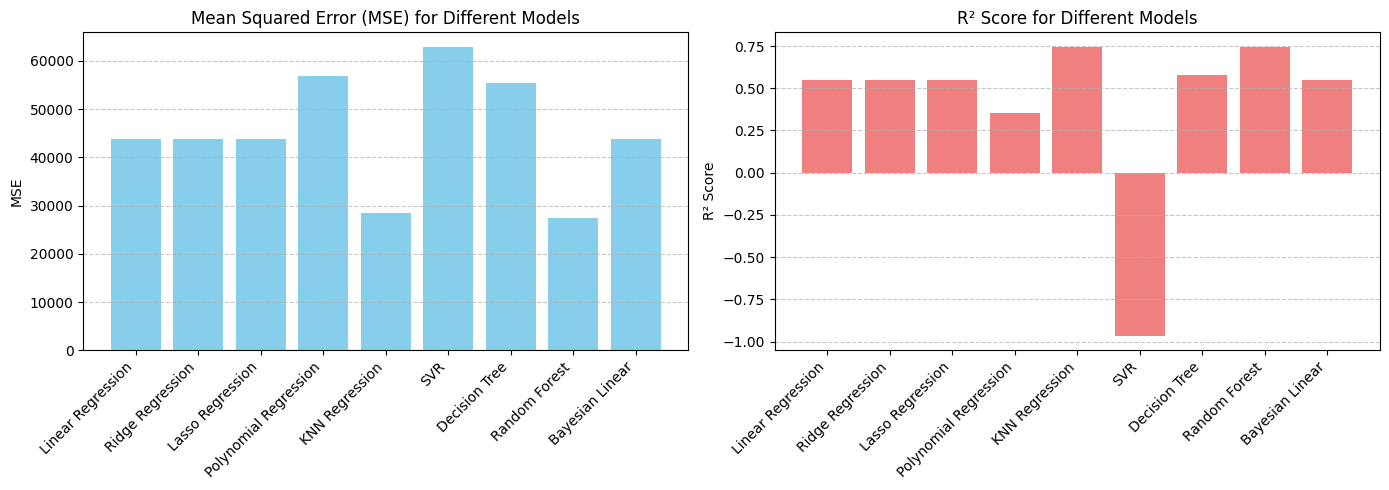

In [ ]:
# Define model names
models = [
    "Linear Regression", "Ridge Regression", "Lasso Regression",
    "Polynomial Regression", "KNN Regression", "SVR",
    "Decision Tree", "Random Forest", "Bayesian Linear"
]

# Define MSE and R² scores for each model
mse_values = [
    mse_linear, mse_ridge, mse_lasso,
    mse_poly, mse_knn, mse_svr,
    mse_dt, mse_rf, mse_bayesian
]

r2_values = [
    r2_linear, r2_ridge, r2_lasso,
    r2_poly, r2_knn, r2_svr,
    r2_dt, r2_rf, r2_bayesian
]

# Set positions for bars
x = np.arange(len(models))

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot MSE bar graph
axes[0].bar(x, mse_values, color='skyblue')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].set_title("Mean Squared Error (MSE) for Different Models")
axes[0].set_ylabel("MSE")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot R² Score bar graph
axes[1].bar(x, r2_values, color='lightcoral')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].set_title("R² Score for Different Models")
axes[1].set_ylabel("R² Score")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Show plots
plt.tight_layout()
plt.show()


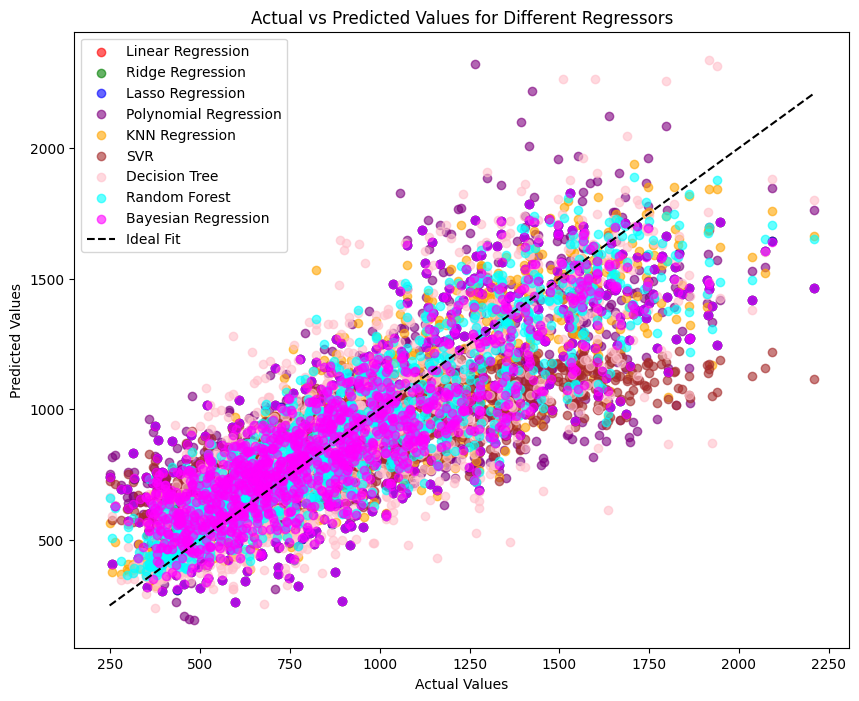

In [ ]:
# Define colors for different models
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'cyan', 'magenta', 'gray', 'yellow']

# Define model names
model_names = [
    "Linear Regression", "Ridge Regression", "Lasso Regression",
    "Polynomial Regression", "KNN Regression", "SVR",
    "Decision Tree", "Random Forest", "Bayesian Regression"
]

# Store predicted values from each model
y_preds = [
    y_pred_linear, y_pred_ridge, y_pred_lasso,
    y_pred_poly, y_pred_knn, y_pred_svr,
    y_pred_dt, y_pred_rf, y_pred_bayesian
]

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 8))
for i, (name, y_pred, color) in enumerate(zip(model_names, y_preds, colors)):
    plt.scatter(y_test, y_pred, color=color, label=name, alpha=0.6)

# Plot the ideal prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label="Ideal Fit")

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Different Regressors')
plt.legend()
plt.show()


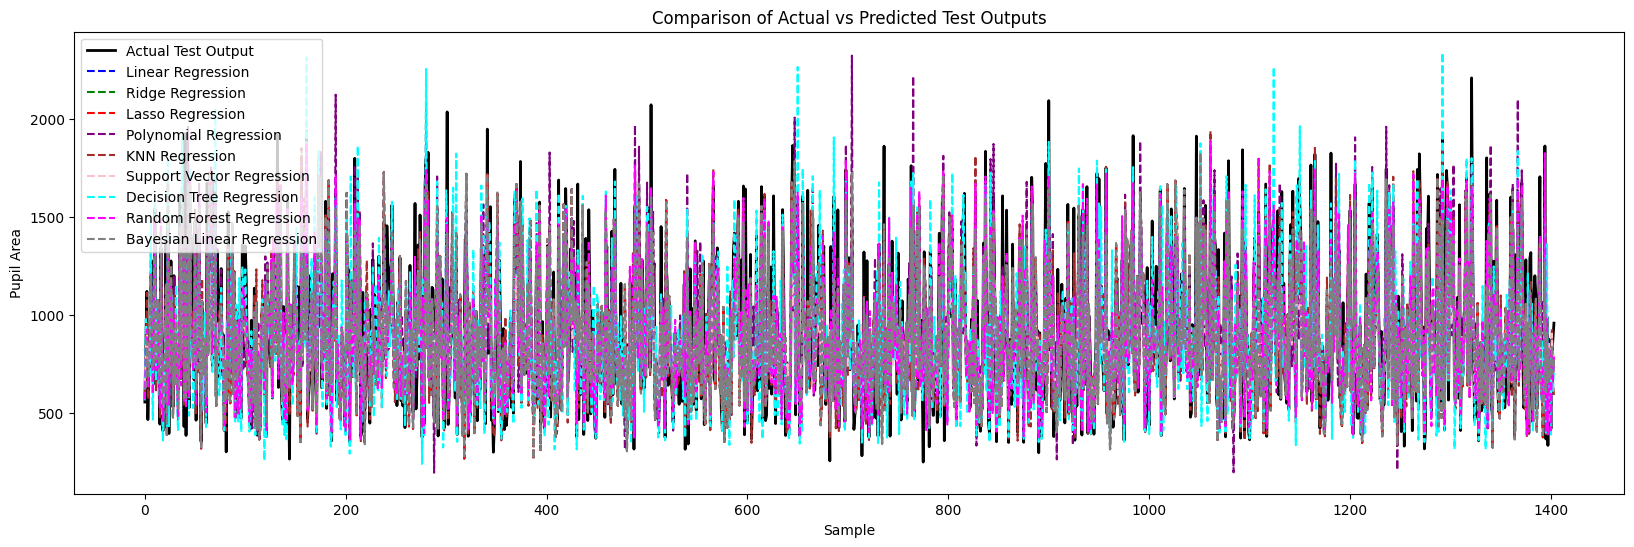

In [ ]:
# Define a dictionary to store model predictions and their corresponding colors
model_predictions = {
    "Linear Regression": (y_pred_linear, 'blue'),
    "Ridge Regression": (y_pred_ridge, 'green'),
    "Lasso Regression": (y_pred_lasso, 'red'),
    "Polynomial Regression": (y_pred_poly, 'purple'),
    "KNN Regression": (y_pred_knn, 'brown'),
    "Support Vector Regression": (y_pred_svr, 'pink'),
    "Decision Tree Regression": (y_pred_dt, 'cyan'),
    "Random Forest Regression": (y_pred_rf, 'magenta'),
    "Bayesian Linear Regression": (y_pred_bayesian, 'gray')
}

# Plot actual test output
plt.figure(figsize=(20, 6))
plt.plot(y_test, 'k', linewidth=2, label="Actual Test Output")

# Plot predictions from different models
for model_name, (y_pred, color) in model_predictions.items():
    plt.plot(y_pred, color=color, linestyle='--', label=model_name)

# Labels and legend
plt.xlabel("Sample")
plt.ylabel("Pupil Area")
plt.title("Comparison of Actual vs Predicted Test Outputs")
plt.legend()
plt.show()
